In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import os
import random
import uuid
import re
from typing import Tuple, List, Optional, Dict
from faker import Faker
from tqdm import tqdm 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import MaxNLocator
from dateutil.relativedelta import relativedelta


In [190]:
# ==============================================================================
# --- CONFIGURATION DICTIONARY ---
# ==============================================================================
fake = Faker()

CONFIG = {
    "INPUT_DATA_DIR": './input_data',
    "INPUT_FILE": "attrition.csv",
    "OUTPUT_DIR": "generated_raw_data",
    "SNAPSHOT_DIR": "snapshots",
    "SNAPSHOT_DATE": date(2024, 12, 31),
    "MAX_TERMINATION_YEARS": 5,
    "OUTPUT_FILES": {
        "hris": "hris_employees_log.csv",
        "reviews": "reviews_log.csv",
        "surveys": "survey_results_log.csv",
        "erp": "erp_financials_log.csv",
    },
    "DEPROMOTION_MAP": {
        # --- Human Resources ---
        ('Human Resources', 2): [('Human Resources', 1)],
        ('Human Resources', 3): [('Human Resources', 2)],
        
        # --- Sales ---
        ('Sales Representative', 2): [('Sales Representative', 1)],
        ('Sales Executive', 2): [('Sales Representative', 1)],
        ('Sales Executive', 3): [('Sales Executive', 2)],
        ('Sales Executive', 4): [('Sales Executive', 3)],
    
        # --- Research & Development ---
        ('Laboratory Technician', 2): [('Laboratory Technician', 1)],
        ('Laboratory Technician', 3): [('Laboratory Technician', 2)],
        ('Research Scientist', 2): [('Research Scientist', 1), ('Laboratory Technician', 1)],
        ('Research Scientist', 3): [('Research Scientist', 2)],
        ('Healthcare Representative', 2): [('Research Scientist', 1)],
        ('Healthcare Representative', 3): [('Healthcare Representative', 2)],
        ('Healthcare Representative', 4): [('Healthcare Representative', 3)],
        ('Manufacturing Director', 2): [('Laboratory Technician', 1)],
        ('Manufacturing Director', 3): [('Manufacturing Director', 2)],
        ('Manufacturing Director', 4): [('Manufacturing Director', 3)],
        ('Research Director', 3): [('Research Scientist', 2)],
        ('Research Director', 4): [('Research Director', 3)],
        ('Research Director', 5): [('Research Director', 4)],
    
        # --- Managerial Paths (Cross-Functional) ---
        ('Manager', 3): [
            ('Sales Executive', 2),          # For Sales
            ('Research Scientist', 2)       # For R&D
        ],
        ('Manager', 4): [
            ('Manager', 3),                  # Generic promotion
            ('Sales Executive', 3),          # For Sales
            ('Human Resources', 2),          # For HR
            ('Healthcare Representative', 3),# For R&D
            ('Manufacturing Director', 3)    # For R&D
        ],
        ('Manager', 5): [
            ('Manager', 4),                  # Generic promotion
            ('Research Director', 4)         # For R&D
        ]
    },
    "ENTRY_LEVEL_ROLES" : [
        ('Sales Representative', 1),  # Sales
        ('Human Resources', 1),       # Human Resources
        ('Laboratory Technician', 1), # R&D
        ('Research Scientist', 1)     # R&D
    ],
    "TENURE_RANGES_YEARS": {
        1: (1.5, 3.0),
        2: (2.0, 4.0),
        3: (2.5, 5.0),
        4: (3.0, 6.0),
        5: (4.0, 8.0),
    },
    "SALARY_BANDS": {},
    "SALARY_BAND_BUFFER": 0.10,
    "SALARY_HIKE_PROMOTION_RANGE": (0.10, 0.20),
    "SALARY_HIKE_ANNUAL_RANGE": (0.02, 0.05),
    "BONUS_PROBABILITY_HIGH_PERF": 0.75,
    "BONUS_PROBABILITY_STD_PERF": 0.25,
    "PERFORMANCE_SCORE_HIGH": (8, 10),
    "PERFORMANCE_SCORE_NORMAL": (5, 7),
    "ATTRITION_GENTLE_DECLINE_START_MONTHS": 18,
    "ATTRITION_SHARP_DECLINE_START_MONTHS": 6,
    "SATISFACTION_GENTLE_DRIFT": -0.75,
    "SATISFACTION_SHARP_DRIFT": -1.5,
    "SURVEY_SCORE_NORMAL_RANGE": (2.5, 4.0),
    "ERP_DEPARTMENT_CODES": {
        "Human Resources": "HR",
        "Sales": "SALES",
        "Research & Development": "RD"
    },
    "REVENUE_PER_HEAD_RANGE": {
        "Sales": (25000, 40000),
        "Research & Development": (15000, 25000),
        "Human Resources": (0, 0)
    },
    "COLA_HIKE_RANGE_PERCENT": (3.0, 4.5),
    "SALARY_OVERHEAD_MULTIPLIER": 1.4,
}

def camel_to_snake(name: str) -> str:
    """Convert camelCase to snake_case."""
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [50]:
def load_source_data(file_path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(file_path)
        print(f"Successfully loaded source data from '{file_path}'.")
        print(f"Found {len(df)} employee records.")
        # Basic validation
        required_cols = ['EmployeeNumber', 'Department', 'JobRole', 'JobLevel', 'MonthlyIncome', 'Attrition', 'TotalWorkingYears']
        for col in required_cols:
            if col not in df.columns:
                raise ValueError(f"Source file is missing required column: '{col}'")
        
        # Rename columns to be more Python-friendly (snake_case)
        df.columns = [camel_to_snake(col) for col in df.columns]

        print("Source data loaded and validated.")
        return df
    except FileNotFoundError:
        print(f"ERROR: The file '{file_path}' was not found.")
        print("Please ensure the attrition.csv file is in the same directory as the script.")
        raise
    except Exception as e:
        print(f"An unexpected error occurred while loading the data: {e}")
        raise

In [51]:
def load_attrition_data()->pd.DataFrame:
    try:
        file_path = os.path.join(CONFIG['INPUT_DATA_DIR'], CONFIG['INPUT_FILE'])
        return load_source_data(file_path)
    except:
        print('\n An error occurred while loading the data ')


In [52]:
try:
    source_df = load_attrition_data()
    print("\nFirst 5 rows of the loaded data:")
    display(source_df.head())
except Exception:
    print("\nHalting execution due to data loading failure.")

Successfully loaded source data from '../data/attrition.csv'.
Found 1470 employee records.
Source data loaded and validated.

First 5 rows of the loaded data:


,age,attrition,business_travel,daily_rate,department,distance_from_home,education,education_field,employee_count,employee_number,...,relationship_satisfaction,standard_hours,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [53]:
def segment_population(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Step 0.2: Segment the population into active and attritted employees.
    """
    active_df = df[df['attrition'] == 'No'].copy()
    attritted_df = df[df['attrition'] == 'Yes'].copy()
    
    print(f"Segmented population: {len(active_df)} active employees, {len(attritted_df)} attritted employees.")
    return active_df, attritted_df

In [54]:
def generate_tenure_dates(employee: pd.Series, snapshot_date: date) -> dict:
    """
    Step 0.3: Calculate hire and termination dates based on tenure.
    """
    tenure_years = employee['total_working_years']
    job_level = employee['job_level']
    
    # Fallback tenure based on job_level if total_working_years is missing
    if pd.isna(tenure_years):
        min_tenure, max_tenure = CONFIG['TENURE_RANGES_YEARS'].get(job_level, (1.5, 3.0))
        tenure_years = random.uniform(min_tenure, max_tenure)
    
    tenure_days = int(tenure_years * 365.25)
    
    if employee['attrition'] == 'No':
        hire_date = snapshot_date - timedelta(days=tenure_days)
        termination_date = None
    else:
        max_days_before_snapshot = CONFIG['MAX_TERMINATION_YEARS'] * 365
        termination_days_ago = random.randint(1, max_days_before_snapshot)
        termination_date = snapshot_date - timedelta(days=termination_days_ago)
        hire_date = termination_date - timedelta(days=tenure_days)
        
        # Ensure hire_date is not in the future
        if hire_date > snapshot_date:
            hire_date = snapshot_date - timedelta(days=tenure_days)
            termination_date = hire_date + timedelta(days=tenure_days)
    
    # Validate hire_date is not unrealistically old
    min_hire_date = date(1900, 1, 1)
    if hire_date < min_hire_date:
        hire_date = min_hire_date
        if termination_date:
            termination_date = hire_date + timedelta(days=tenure_days)
    
    return {
        'employee_id': employee['employee_number'],
        'hire_date': hire_date,
        'termination_date': termination_date
    }

In [55]:
def calculate_employee_timelines(df: pd.DataFrame, snapshot_date: date) -> pd.DataFrame:
    """
    Apply timeline generation to all employees and return a DataFrame with timelines.
    """
    timelines = []
    for _, employee in df.iterrows():
        timeline = generate_tenure_dates(employee, snapshot_date)
        timelines.append(timeline)
    
    timeline_df = pd.DataFrame(timelines)
    print(f"Generated timelines for {len(timeline_df)} employees.")
    
    # Validation checks
    invalid_hires = timeline_df[timeline_df['hire_date'] > snapshot_date]
    if not invalid_hires.empty:
        print(f"Warning: {len(invalid_hires)} employees have hire dates after snapshot date.")
    
    old_hires = timeline_df[timeline_df['hire_date'] < date(1900, 1, 1)]
    if not old_hires.empty:
        print(f"Warning: {len(old_hires)} employees have hire dates before 1900.")
    
    return timeline_df

In [56]:
active_df, attritted_df = segment_population(source_df)

Segmented population: 1233 active employees, 237 attritted employees.


In [57]:
active_timelines = calculate_employee_timelines(active_df, CONFIG['SNAPSHOT_DATE'])


Generated timelines for 1233 employees.


In [60]:
attritted_timelines = calculate_employee_timelines(attritted_df, CONFIG['SNAPSHOT_DATE'])


Generated timelines for 237 employees.


In [62]:
all_timelines = pd.concat([active_timelines, attritted_timelines], ignore_index=True)
print("\nFirst 5 rows of combined timelines:")
print(all_timelines.head())
print(attritted_timelines.head())


First 5 rows of combined timelines:
   employee_id   hire_date termination_date
0            2  2015-01-01             None
1            5  2016-12-31             None
2            7  2019-01-01             None
3            8  2016-12-31             None
4           10  2012-12-31             None
   employee_id   hire_date termination_date
0            1  2015-04-11       2023-04-11
1            4  2013-09-27       2020-09-26
2           19  2017-08-16       2023-08-16
3           27  2013-11-13       2023-11-13
4           31  2015-08-02       2023-08-02


In [65]:
def calculate_salary_bands(df: pd.DataFrame) -> None:
    salary_bands = {}
    buffer = CONFIG['SALARY_BAND_BUFFER']
    
    # Group by job_role and job_level to compute min/max MonthlyIncome
    salary_groups = df.groupby(['job_role', 'job_level'])['monthly_income'].agg(['min', 'max']).reset_index()
    
    for _, row in salary_groups.iterrows():
        role = row['job_role']
        level = row['job_level']
        min_salary = row['min']
        max_salary = row['max']
        
        # Apply buffer
        min_salary_buffered = min_salary * (1 - buffer)
        max_salary_buffered = max_salary * (1 + buffer)
        
        # Ensure min_salary is at least positive
        min_salary_buffered = max(0, min_salary_buffered)
        
        salary_bands[(role, level)] = (min_salary_buffered, max_salary_buffered)
    
    # Validate that all roles in DEPROMOTION_MAP have salary bands
    for role_level in CONFIG['DEPROMOTION_MAP'].keys():
        if role_level not in salary_bands:
            # Use a default band if no data exists (rare case)
            salary_bands[role_level] = (1000, 5000)  # Reasonable default
            print(f"Warning: No salary data for {role_level}. Using default band (1000, 5000).")
    
    CONFIG['SALARY_BANDS'] = salary_bands
    print(f"Calculated salary bands for {len(salary_bands)} role-level combinations.")


In [98]:
def get_previous_role(current_role: str, current_level: int, department: str) -> Optional[Tuple[str, int]]:
    current_key = (current_role, current_level)

    if current_key in CONFIG['ENTRY_LEVEL_ROLES']:
        return None

    possible_previous_roles = CONFIG['DEPROMOTION_MAP'].get(current_key)

    if not possible_previous_roles:
        return None
        
    role_to_dept_map = {
        'Human Resources': 'Human Resources',
        'Sales Representative': 'Sales',
        'Sales Executive': 'Sales',
        'Laboratory Technician': 'Research & Development',
        'Research Scientist': 'Research & Development',
        'Healthcare Representative': 'Research & Development',
        'Manufacturing Director': 'Research & Development',
        'Research Director': 'Research & Development'
    }

    valid_previous_options = []
    for prev_role, prev_level in possible_previous_roles:
        
        previous_role_dept = role_to_dept_map.get(prev_role)

        if prev_role == 'Manager' or (previous_role_dept and previous_role_dept == department):
            valid_previous_options.append((prev_role, prev_level))

    if not valid_previous_options:
        return None

    return random.choice(valid_previous_options)

In [99]:
# Diagnostic to verify DEPROMOTION_MAP
try:
    print("Verifying DEPROMOTION_MAP:")
    # Check key roles
    key_roles = [
        ('Manager', 3, 'Sales'),
        ('Manager', 3, 'Human Resources'),
        ('Manager', 3, 'Research & Development'),
        ('Sales Executive', 4, 'Sales'),
        ('Human Resources', 3, 'Human Resources'),
        ('Laboratory Technician', 2, 'Research & Development')
    ]
    for role, level, dept in key_roles:
        prev = get_previous_role(role,level,dept)
        print(f"Previous role for ({role}, {level}, {dept}): {prev}")
    
    # Verify dataset coverage
    unique_roles = source_df[['job_role', 'job_level']].drop_duplicates().values
    missing_roles = [(role, level) for role, level in unique_roles if (role, level) not in CONFIG['DEPROMOTION_MAP'] and (role, level) not in CONFIG['ENTRY_LEVEL_ROLES']]
    if missing_roles:
        print(f"Warning: {len(missing_roles)} role-level combos not in DEPROMOTION_MAP or ENTRY_LEVEL_ROLES: {missing_roles}")
    else:
        print("All role-level combos in dataset are covered by DEPROMOTION_MAP or ENTRY_LEVEL_ROLES.")
    
except Exception as e:
    print(f"Error in DEPROMOTION_MAP verification: {e}")

Verifying DEPROMOTION_MAP:
Previous role for (Manager, 3, Sales): ('Sales Executive', 2)
Previous role for (Manager, 3, Human Resources): None
Previous role for (Manager, 3, Research & Development): ('Research Scientist', 2)
Previous role for (Sales Executive, 4, Sales): ('Sales Executive', 3)
Previous role for (Human Resources, 3, Human Resources): ('Human Resources', 2)
Previous role for (Laboratory Technician, 2, Research & Development): ('Laboratory Technician', 1)
All role-level combos in dataset are covered by DEPROMOTION_MAP or ENTRY_LEVEL_ROLES.


In [69]:
def validate_career_model() -> None:
    # Check for missing roles in DEPROMOTION_MAP
    all_roles = set(CONFIG['DEPROMOTION_MAP'].keys())
    for prev_roles in CONFIG['DEPROMOTION_MAP'].values():
        for role_level in prev_roles:
            if role_level not in all_roles and role_level not in CONFIG['ENTRY_LEVEL_ROLES']:
                print(f"Warning: Role {role_level} is a previous role but not defined in DEPROMOTION_MAP or ENTRY_LEVEL_ROLES.")
    
    # Check if all entry-level roles have no previous roles
    for entry_role in CONFIG['ENTRY_LEVEL_ROLES']:
        if entry_role in CONFIG['DEPROMOTION_MAP']:
            print(f"Warning: Entry-level role {entry_role} has previous roles defined in DEPROMOTION_MAP.")
    
    print("Career model validation completed.")

In [100]:
try:
    # Calculate salary bands
    calculate_salary_bands(source_df)
    print("Sample salary bands:", dict(list(CONFIG['SALARY_BANDS'].items())[:5]))
    
    # Validate career model
    validate_career_model()
    
    # Test get_previous_role
    test_cases = [
        ('Manager', 5, 'Sales'),
        ('Sales Executive', 3, 'Sales'),
        ('Laboratory Technician', 2, 'Research & Development'),
        ('Research Scientist', 2, 'Research & Development')
    ]
    for role, level, dept in test_cases:
        prev_role = get_previous_role(role, level, dept)
        print(f"Previous role for ({role}, {level}, {dept}): {prev_role}")
except Exception as e:
    print(f"Error in Step 0.4: {e}")

Calculated salary bands for 26 role-level combinations.
Sample salary bands: {('Healthcare Representative', 2): (3600.0, 10806.400000000001), ('Healthcare Representative', 3): (6304.5, 12098.900000000001), ('Healthcare Representative', 4): (9992.7, 15362.6), ('Human Resources', 1): (1399.5, 5429.6), ('Human Resources', 2): (3497.4, 7073.000000000001)}
Career model validation completed.
Previous role for (Manager, 5, Sales): ('Manager', 4)
Previous role for (Sales Executive, 3, Sales): ('Sales Executive', 2)
Previous role for (Laboratory Technician, 2, Research & Development): ('Laboratory Technician', 1)
Previous role for (Research Scientist, 2, Research & Development): ('Research Scientist', 1)


In [104]:
def generate_employee_career_history(
    employee: pd.Series,
    timeline: pd.Series,
    snapshot_date: date
) -> List[Dict]:
    events = []
    
    end_date = snapshot_date if pd.isna(timeline['termination_date']) else timeline['termination_date']
    current_date = end_date
    current_role = employee['job_role']
    current_level = employee['job_level']
    current_department = employee['department']
    current_salary = employee['monthly_income']
    hire_date = timeline['hire_date']

    full_name = fake.name()

    email_name = full_name.lower().replace(' ', '.')
    email = f"{email_name}@{fake.free_email_domain()}"

    while True: 
        prev_role_level = get_previous_role(current_role, current_level, current_department)

        if prev_role_level is None:
            break

        prev_role, prev_level = prev_role_level
        
        min_tenure, max_tenure = CONFIG['TENURE_RANGES_YEARS'].get(current_level, (2.0, 4.0))
        tenure_years = random.uniform(min_tenure, max_tenure)
        tenure_days = int(tenure_years * 365.25)

        event_date = current_date - timedelta(days=tenure_days)


        if event_date <= hire_date:
            break 
            
        promotion_hike = random.uniform(*CONFIG['SALARY_HIKE_PROMOTION_RANGE'])
        prev_salary = current_salary / (1 + promotion_hike)
        
        min_band_salary, max_band_salary = CONFIG['SALARY_BANDS'].get((prev_role, prev_level), (1000, 5000))
        prev_salary = max(min_band_salary, min(max_band_salary, prev_salary))
        
        events.append({
            'event_date': event_date,
            'employee_id': employee['employee_number'],
            'full_name': full_name,
            'email': email,
            'job_level': prev_level,
            'job_role': prev_role,
            'department_name': current_department,
            'salary': round(prev_salary, 2),
            'is_currently_active': True 
        })

        current_date = event_date
        current_role = prev_role
        current_level = prev_level
        current_salary = prev_salary

    events.append({
        'event_date': hire_date,
        'employee_id': employee['employee_number'],
        'full_name': full_name,
        'email': email,
        'job_level': current_level, 
        'job_role': current_role,   
        'department_name': current_department,
        'salary': round(current_salary, 2),
        'is_currently_active': True
    })

    events.append({
        'event_date': end_date,
        'employee_id': employee['employee_number'],
        'full_name': full_name,
        'email': email,
        'job_level': employee['job_level'], 
        'job_role': employee['job_role'],   
        'department_name': employee['department'],
        'salary': employee['monthly_income'],
        'is_currently_active': employee['attrition'] == 'No'
    })
    
    final_events_df = pd.DataFrame(events)
    final_events_df = final_events_df.drop_duplicates(subset=['employee_id', 'event_date'], keep='last')
    
    return final_events_df.to_dict('records')

In [102]:
def generate_all_career_histories(
    source_df: pd.DataFrame,
    timelines_df: pd.DataFrame,
    snapshot_date: date
) -> List[Dict]:
    """
    Generate career histories for all employees.
    Returns a flat list of all event records.
    """
    all_events = []
    
    for _, employee in source_df.iterrows():
        employee_id = employee['employee_number']
        timeline = timelines_df[timelines_df['employee_id'] == employee_id]
        if timeline.empty:
            print(f"Warning: No timeline found for employee {employee_id}. Skipping.")
            continue
        timeline = timeline.iloc[0]
        
        events = generate_employee_career_history(employee, timeline, snapshot_date)
        all_events.extend(events)
    
    print(f"Generated {len(all_events)} career history events for {len(source_df)} employees.")
    return all_events

In [105]:
try:
    career_events = generate_all_career_histories(source_df, all_timelines, CONFIG['SNAPSHOT_DATE'])
    
    career_events_df = pd.DataFrame(career_events)
    
    career_events_df.to_csv('career_events_temp.csv', index=False)
    print("Saved career events to 'career_events_temp.csv' for inspection.")
    
    print("\nSample career events (first 5 rows):")
    display(career_events_df.head())
    
    if (career_events_df['salary'] < 0).any():
        print("Warning: Negative salaries detected.")
    if (career_events_df['event_date'] > CONFIG['SNAPSHOT_DATE']).any():
        print("Warning: Event dates after snapshot date detected.")
    if (career_events_df['event_date'] < all_timelines['hire_date'].min()).any():
        print("Warning: Event dates before earliest hire date detected.")
    
except Exception as e:
    print(f"Error in Step 1: {e}")

Generated 4473 career history events for 1470 employees.
Saved career events to 'career_events_temp.csv' for inspection.

Sample career events (first 5 rows):


,event_date,employee_id,full_name,email,job_level,job_role,department_name,salary,is_currently_active
0,2020-09-15,1,Scott Garcia,scott.garcia@gmail.com,1,Sales Representative,Sales,4840.00,True
1,2015-04-11,1,Scott Garcia,scott.garcia@gmail.com,1,Sales Representative,Sales,4840.00,True
2,2023-04-11,1,Scott Garcia,scott.garcia@gmail.com,2,Sales Executive,Sales,5993.00,False
3,2021-06-20,2,Martha Roy,martha.roy@gmail.com,1,Research Scientist,Research & Development,4486.03,True
4,2015-01-01,2,Martha Roy,martha.roy@gmail.com,1,Research Scientist,Research & Development,4486.03,True


In [106]:
def generate_dates_in_period(start_date: date, end_date: date, frequency: str) -> List[date]:
    """Generates a list of dates between start and end based on frequency."""
    dates = []
    current_date = start_date
    
    if frequency == 'annual':
        offset = random.randint(180, 365)
        current_date += timedelta(days=offset)
        while current_date < end_date:
            dates.append(current_date)
            current_date += timedelta(days=random.randint(350, 380)) # Jitter
    elif frequency == 'quarterly':
        offset = random.randint(30, 90)
        current_date += timedelta(days=offset)
        while current_date < end_date:
            dates.append(current_date)
            current_date += timedelta(days=random.randint(85, 95)) # Jitter
    
    return dates


In [116]:
def generate_performance_and_survey_histories(
    source_df: pd.DataFrame,
    timelines_df: pd.DataFrame,
    career_events_df: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame]:

    all_reviews = []
    all_surveys = []
    
    career_events_df['is_promotion'] = career_events_df['job_level'] > career_events_df.groupby('employee_id')['job_level'].shift(1).fillna(0)
    promotion_dates_map = career_events_df[career_events_df['is_promotion']].groupby('employee_id')['event_date'].apply(list).to_dict()

    for _, employee in tqdm(source_df.iterrows(), total=source_df.shape[0], desc="Generating reviews & surveys"):
        employee_id = employee['employee_number']
        
        timeline = timelines_df.loc[timelines_df['employee_id'] == employee_id].iloc[0]
        hire_date = timeline['hire_date']
        termination_date = timeline['termination_date']
        did_attrit = pd.notna(termination_date)
        end_date = termination_date if did_attrit else CONFIG['SNAPSHOT_DATE']

        promotion_dates = promotion_dates_map.get(employee_id, [])

        review_dates = generate_dates_in_period(hire_date, end_date, 'annual')
        for review_date in review_dates:
            is_pre_promotion = any(0 < (promo_date - review_date).days <= (365 * 2) for promo_date in promotion_dates)
            
            if is_pre_promotion:
                performance_score = random.randint(*CONFIG['PERFORMANCE_SCORE_HIGH'])
                salary_hike_percent = employee['percent_salary_hike'] * random.uniform(1.1, 1.3)
                bonus_granted = random.random() < CONFIG['BONUS_PROBABILITY_HIGH_PERF']
            else:
                performance_score = random.randint(*CONFIG['PERFORMANCE_SCORE_NORMAL'])
                salary_hike_percent = employee['percent_salary_hike'] * random.uniform(0.8, 1.1)
                bonus_granted = random.random() < CONFIG['BONUS_PROBABILITY_STD_PERF']

            all_reviews.append({
                'review_date': review_date,
                'employee_id': employee_id,
                'performance_score': performance_score,
                'salary_hike_percent': round(salary_hike_percent, 1),
                'bonus_granted': bonus_granted
            })
            
        survey_dates = generate_dates_in_period(hire_date, end_date, 'quarterly')
        
        base_env_sat = employee['environment_satisfaction']
        base_job_inv = employee['job_involvement']
        base_rel_sat = employee['relationship_satisfaction']
        base_job_sat = employee['job_satisfaction']

        for survey_date in survey_dates:

            env_sat = base_env_sat + random.choice([-1, 0, 0, 1])
            job_inv = base_job_inv + random.choice([-1, 0, 0, 1])
            rel_sat = base_rel_sat + random.choice([-1, 0, 0, 1])
            job_sat = base_job_sat + random.choice([-1, 0, 0, 1])

            if did_attrit:
                days_to_termination = (termination_date - survey_date).days
                
                if 0 < days_to_termination <= CONFIG['ATTRITION_SHARP_DECLINE_START_MONTHS'] * 30:
                    if random.random() < 0.75: env_sat -= 1 # 75% chance to drop
                    if random.random() < 0.80: job_sat -= 1 # 80% chance to drop
                    if random.random() < 0.50: job_inv -= 1 # 50% chance to drop
                
                elif CONFIG['ATTRITION_SHARP_DECLINE_START_MONTHS'] * 30 < days_to_termination <= CONFIG['ATTRITION_GENTLE_DECLINE_START_MONTHS'] * 30:
                    if random.random() < 0.35: env_sat -= 1 # 35% chance to drop
                    if random.random() < 0.40: job_sat -= 1 # 40% chance to drop

            # Clamp all scores to be integers within the valid 1-4 range
            all_surveys.append({
                'survey_date': survey_date,
                'employee_id': employee_id,
                'env_satisfaction_score': max(1, min(4, int(round(env_sat)))),
                'job_involvement_score': max(1, min(4, int(round(job_inv)))),
                'relationship_satisfaction_score': max(1, min(4, int(round(rel_sat)))),
                'job_satisfaction_score': max(1, min(4, int(round(job_sat))))
            })

    reviews_df = pd.DataFrame(all_reviews).sort_values('review_date').reset_index(drop=True)
    surveys_df = pd.DataFrame(all_surveys).sort_values('survey_date').reset_index(drop=True)
    
    print(f"\nGenerated {len(reviews_df)} performance review records.")
    print(f"Generated {len(surveys_df)} survey result records with integer scores.")
    
    return reviews_df, surveys_df

In [117]:
try:
    reviews_df, surveys_df = generate_performance_and_survey_histories(
        source_df,
        all_timelines,
        career_events_df
    )
    
    print("\n--- Sample Performance Reviews Log ---")
    display(reviews_df.head())
    
    print("\n--- Sample Survey Results Log ---")
    display(surveys_df.head())
    
    # Save to temporary CSVs for inspection
    reviews_df.to_csv('reviews_log_temp.csv', index=False)
    surveys_df.to_csv('survey_results_log_temp.csv', index=False)
    print("\nSaved temporary logs to 'reviews_log_temp.csv' and 'survey_results_log_temp.csv'.")

except Exception as e:
    print(f"\nAn error occurred during Step 2 generation: {e}")
    # If you get an error here, it's likely due to one of the input DataFrames 
    # not being defined. Make sure you've run the previous cells.
    import traceback
    traceback.print_exc()

Generating reviews & surveys: 100%|██████████████████████| 1470/1470 [00:00<00:00, 2207.46it/s]



Generated 16519 performance review records.
Generated 67026 survey result records with integer scores.

--- Sample Performance Reviews Log ---


,review_date,employee_id,performance_score,salary_hike_percent,bonus_granted
0,1984-06-03,165,6,12.9,False
1,1984-06-25,825,7,10.6,False
2,1985-06-10,165,5,12.4,False
3,1985-07-07,825,7,10.2,True
4,1986-06-04,165,7,11.4,False



--- Sample Survey Results Log ---


,survey_date,employee_id,env_satisfaction_score,job_involvement_score,relationship_satisfaction_score,job_satisfaction_score
0,1983-09-17,165,4,2,4,3
1,1983-12-17,165,3,3,4,4
2,1984-01-21,825,4,3,4,2
3,1984-03-16,165,4,3,4,4
4,1984-04-16,825,4,3,4,2



Saved temporary logs to 'reviews_log_temp.csv' and 'survey_results_log_temp.csv'.


In [155]:
def generate_final_hris_log(
    source_df: pd.DataFrame,
    initial_career_events_df: pd.DataFrame,
    reviews_df: pd.DataFrame,
    timelines_df: pd.DataFrame
) -> pd.DataFrame:

    print("Starting final HRIS log generation with EVENT-DRIVEN BACK-CASTING...")
    final_hris_records = []

    employee_details_map = initial_career_events_df.groupby('employee_id').first()

    for _, employee in tqdm(source_df.iterrows(), total=source_df.shape[0], desc="Processing employee salaries"):
        employee_id = employee['employee_number']

        career_events = initial_career_events_df[initial_career_events_df['employee_id'] == employee_id]
        reviews = reviews_df[reviews_df['employee_id'] == employee_id]
        timeline = timelines_df[timelines_df['employee_id'] == employee_id].iloc[0]

        promo_dates = career_events['event_date'].tolist()
        review_dates = reviews['review_date'].tolist()
        event_dates = sorted(list(set(promo_dates + review_dates + [timeline['hire_date']])))
        
        review_hike_map = {dt.strftime('%Y-%m-%d'): hike for dt, hike in zip(reviews['review_date'], reviews['salary_hike_percent'])}

        is_active_final = pd.isna(timeline['termination_date'])
        end_date = CONFIG['SNAPSHOT_DATE'] if is_active_final else timeline['termination_date']
        
        period_boundaries = [end_date] + [d for d in reversed(event_dates) if d < end_date]
        
        current_salary = employee['monthly_income']

        for i in range(len(period_boundaries) - 1):
            period_start_date = period_boundaries[i]
            period_end_date = period_boundaries[i+1]
            
            salary_for_this_period = current_salary


            month_iter = period_start_date.replace(day=1)
            while month_iter > period_end_date:
                state_at_date = career_events[career_events['event_date'] <= month_iter].sort_values('event_date', ascending=False).iloc[0]
                
                final_hris_records.append({
                    'event_date': month_iter, 'employee_id': employee_id,
                    'full_name': employee_details_map.loc[employee_id, 'full_name'],
                    'email': employee_details_map.loc[employee_id, 'email'],
                    'job_level': state_at_date['job_level'], 'job_role': state_at_date['job_role'],
                    'department_name': state_at_date['department_name'], 'salary': round(salary_for_this_period, 2),
                    'is_currently_active': True
                })
                month_iter -= relativedelta(months=1)

            event_date_str = period_end_date.strftime('%Y-%m-%d')

            if period_end_date in promo_dates and period_end_date != timeline['hire_date']:
                promo_hike = random.uniform(*CONFIG['SALARY_HIKE_PROMOTION_RANGE'])
                current_salary /= (1 + promo_hike)
            
            if event_date_str in review_hike_map:
                perf_hike = review_hike_map[event_date_str] / 100.0
                cola_hike = random.uniform(*CONFIG['COLA_HIKE_RANGE_PERCENT']) / 100.0
                current_salary /= (1 + perf_hike + cola_hike)
        
        final_hris_records.append({
            'event_date': end_date, 'employee_id': employee_id,
            'full_name': employee_details_map.loc[employee_id, 'full_name'],
            'email': employee_details_map.loc[employee_id, 'email'],
            'job_level': employee['job_level'], 'job_role': employee['job_role'],
            'department_name': employee['department'], 'salary': employee['monthly_income'],
            'is_currently_active': is_active_final
        })

    final_hris_df = pd.DataFrame(final_hris_records)
    final_hris_df.drop_duplicates(subset=['employee_id', 'event_date'], keep='last', inplace=True)
    final_hris_df = final_hris_df.sort_values(by=['employee_id', 'event_date']).reset_index(drop=True)
    
    print(f"\nSuccessfully generated final HRIS log with {len(final_hris_df)} records.")
    return final_hris_df


In [156]:
try:
    final_hris_df = generate_final_hris_log(
        source_df,
        career_events_df, 
        reviews_df,
        all_timelines
    )

    print("\n--- Sample of Final, Corrected HRIS Log ---")
    display(final_hris_df.head())

    print("\n--- Spot Check: Salary History for Employee #10 ---")
    employee_10_history = final_hris_df[final_hris_df['employee_id'] == 10]
    display(employee_10_history[['event_date', 'job_role', 'job_level', 'salary']])

    final_hris_df.to_csv('hris_employees_log_temp.csv', index=False)
    print("\nSaved final HRIS log to 'hris_employees_log_temp.csv'.")
    
except Exception as e:
    print(f"\nAn error occurred during Step 3 generation: {e}")
    import traceback
    traceback.print_exc()

Starting final HRIS log generation with EVENT-DRIVEN BACK-CASTING...


Processing employee salaries: 100%|████████████████████████| 1470/1470 [01:34<00:00, 15.52it/s]



Successfully generated final HRIS log with 199491 records.

--- Sample of Final, Corrected HRIS Log ---


,event_date,employee_id,full_name,email,job_level,job_role,department_name,salary,is_currently_active
0,2015-05-01,1,Scott Garcia,scott.garcia@gmail.com,1,Sales Representative,Sales,1549.91,True
1,2015-06-01,1,Scott Garcia,scott.garcia@gmail.com,1,Sales Representative,Sales,1549.91,True
2,2015-07-01,1,Scott Garcia,scott.garcia@gmail.com,1,Sales Representative,Sales,1549.91,True
3,2015-08-01,1,Scott Garcia,scott.garcia@gmail.com,1,Sales Representative,Sales,1549.91,True
4,2015-09-01,1,Scott Garcia,scott.garcia@gmail.com,1,Sales Representative,Sales,1549.91,True



--- Spot Check: Salary History for Employee #10 ---


,event_date,job_role,job_level,salary
568,2013-01-01,Laboratory Technician,1,234.32
569,2013-02-01,Laboratory Technician,1,234.32
570,2013-03-01,Laboratory Technician,1,234.32
571,2013-04-01,Laboratory Technician,1,234.32
572,2013-05-01,Laboratory Technician,1,234.32
...,...,...,...,...
708,2024-09-01,Laboratory Technician,1,2139.84
709,2024-10-01,Laboratory Technician,1,2139.84
710,2024-11-01,Laboratory Technician,1,2670.00
711,2024-12-01,Laboratory Technician,1,2670.00



Saved final HRIS log to 'hris_employees_log_temp.csv'.


In [188]:
def plot_employee_salary_evolution(
    employee_id: int, 
    hris_log_df: pd.DataFrame, 
    reviews_log_df: pd.DataFrame,
    timelines_df: pd.DataFrame
):
    employee_history = hris_log_df[hris_log_df['employee_id'] == employee_id].copy()
    if employee_history.empty:
        print(f"Error: Employee with ID {employee_id} not found in the HRIS log.")
        return
        
    employee_reviews = reviews_log_df[reviews_log_df['employee_id'] == employee_id]
    employee_timeline = timelines_df[timelines_df['employee_id'] == employee_id].iloc[0]
    
    employee_history = employee_history.sort_values('event_date')
    
    employee_history['is_promotion'] = employee_history['job_level'] > employee_history['job_level'].shift(1)
    promotions = employee_history[employee_history['is_promotion'] == True]

    fig, ax = plt.subplots(figsize=(15, 8))

    ax.step(
        employee_history['event_date'], 
        employee_history['salary'], 
        where='post', 
        label='Salary', 
        linewidth=2.5,
        color='#1f77b4' # A nice blue color
    )
    
    # Plot markers for promotions/hire events
    ax.plot(
        promotions['event_date'], 
        promotions['salary'], 
        'o', # Circle markers
        color='green', 
        markersize=10, 
        label='Promotion / Hire'
    )

    for review_date in employee_reviews['review_date']:
        ax.axvline(x=review_date, color='grey', linestyle='--', linewidth=0.8, alpha=0.7)
    
    ax.plot([], [], color='grey', linestyle='--', label='Annual Review Date')

    hire_date = employee_timeline['hire_date']
    ax.axvline(x=hire_date, color='blue', linestyle='-.', label=f'Hired: {hire_date.strftime("%Y-%m-%d")}')
    
    if pd.notna(employee_timeline['termination_date']):
        term_date = employee_timeline['termination_date']
        ax.axvline(x=term_date, color='red', linestyle='-.', label=f'Terminated: {term_date.strftime("%Y-%m-%d")}')

    final_role = employee_history.iloc[-1]['job_role']
    ax.set_title(f"Salary & Career Evolution for Employee ID: {employee_id} (Final Role: {final_role})", fontsize=16)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Monthly Salary", fontsize=12)
    
    # Format Y-axis as currency
    ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
    
    # Format X-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    
    ax.legend(fontsize=10)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


In [187]:
def plot_employee_performance_evolution(
    employee_id: int,
    reviews_log_df: pd.DataFrame,
    hris_log_df: pd.DataFrame,
    timelines_df: pd.DataFrame
):
    employee_reviews = reviews_log_df[reviews_log_df['employee_id'] == employee_id].copy()
    if employee_reviews.empty:
        print(f"Error: No performance reviews found for Employee ID {employee_id}.")
        return

    employee_history = hris_log_df[hris_log_df['employee_id'] == employee_id].copy()
    employee_timeline = timelines_df[timelines_df['employee_id'] == employee_id].iloc[0]
    
    employee_history['is_promotion'] = employee_history['job_level'] > employee_history['job_level'].shift(1)
    promotions = employee_history[employee_history['is_promotion'] == True]

    fig, ax = plt.subplots(figsize=(15, 7))

    ax.axhspan(
        CONFIG['PERFORMANCE_SCORE_NORMAL'][0], 
        CONFIG['PERFORMANCE_SCORE_NORMAL'][1] + 1, # +1 to fill the band correctly
        color='orange', 
        alpha=0.2, 
        label='Normal Performance'
    )
    ax.axhspan(
        CONFIG['PERFORMANCE_SCORE_HIGH'][0], 
        CONFIG['PERFORMANCE_SCORE_HIGH'][1] + 1, # +1 to fill the band correctly
        color='green', 
        alpha=0.2, 
        label='High Performance'
    )
    
    ax.plot(
        employee_reviews['review_date'],
        employee_reviews['performance_score'],
        marker='o',
        linestyle='-',
        label='Performance Score',
        color='#00529B' # A strong blue
    )

    if not promotions.empty:
        for promo_date in promotions['event_date'].unique():
            # Skip hire date for promotion marker
            if promo_date > employee_timeline['hire_date']:
                ax.axvline(x=promo_date, color='green', linestyle='--', linewidth=1.5)
        # Add a single legend entry for all promotion lines
        ax.plot([], [], color='green', linestyle='--', label='Promotion Date')

    # Add lines for hire and termination
    hire_date = employee_timeline['hire_date']
    ax.axvline(x=hire_date, color='blue', linestyle='-.', label=f'Hired')
    
    if pd.notna(employee_timeline['termination_date']):
        term_date = employee_timeline['termination_date']
        ax.axvline(x=term_date, color='red', linestyle='-.', label=f'Terminated')
        
    ax.set_title(f"Performance Review History for Employee ID: {employee_id}", fontsize=16)
    ax.set_xlabel("Date", fontsize=12)
    ax.set_ylabel("Performance Score (1-10)", fontsize=12)
    
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(0, 11)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

--- Displaying performance evolution for a promoted employee: ID 966 ---

An unexpected error occurred during plotting: Cannot compare Timestamp with datetime.date. Use ts == pd.Timestamp(date) or ts.date() == date instead.


Traceback (most recent call last):
  File "/tmp/ipykernel_1057739/2710308852.py", line 10, in <module>
    plot_employee_performance_evolution(employee_to_test, reviews_df, final_hris_df, all_timelines)
  File "/tmp/ipykernel_1057739/2962700897.py", line 54, in plot_employee_performance_evolution
    if promo_date > employee_timeline['hire_date']:
  File "timestamps.pyx", line 377, in pandas._libs.tslibs.timestamps._Timestamp.__richcmp__
TypeError: Cannot compare Timestamp with datetime.date. Use ts == pd.Timestamp(date) or ts.date() == date instead.


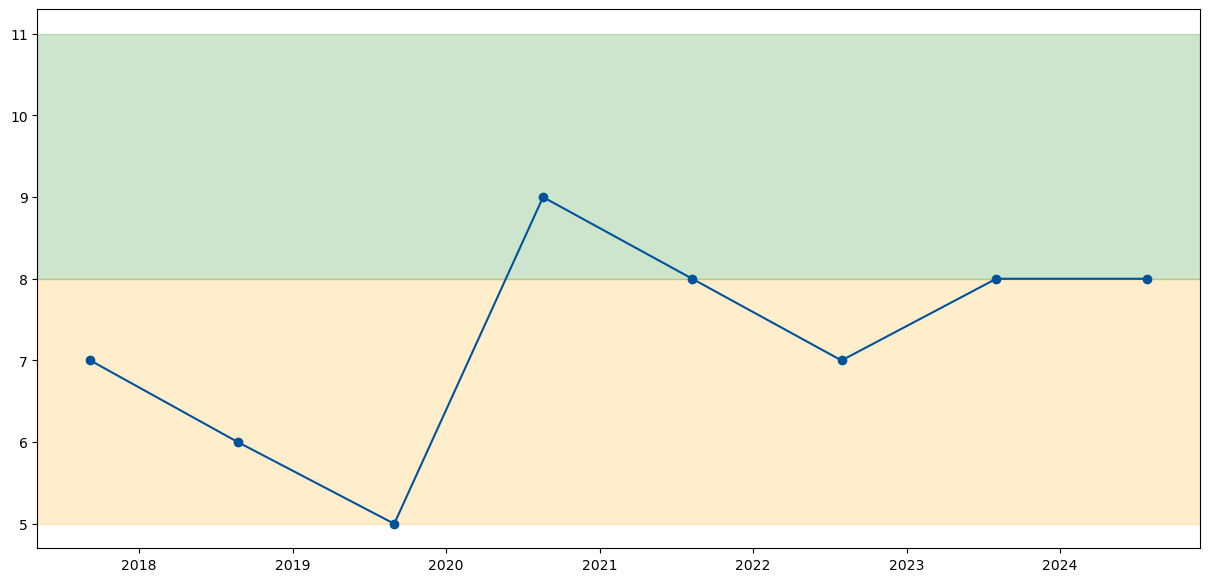

In [186]:
try:
    # Find all employee IDs that have more than one job level in their history
    promoted_employee_ids = final_hris_df.groupby('employee_id')['job_level'].nunique()
    promoted_employee_ids = promoted_employee_ids[promoted_employee_ids > 1].index
    
    if not promoted_employee_ids.empty:
        # Select a random employee from the list of those who were promoted
        employee_to_test = random.choice(promoted_employee_ids)
        print(f"--- Displaying performance evolution for a promoted employee: ID {employee_to_test} ---")
        plot_employee_performance_evolution(employee_to_test, reviews_df, final_hris_df, all_timelines)
    else:
        print("Could not find any employees with promotions in the generated data to test.")

except NameError as e:
    print(f"\nCould not run the plotting function. Make sure the DataFrames from previous steps are loaded.")
    print(f"Error details: {e}")
except Exception as e:
    print(f"\nAn unexpected error occurred during plotting: {e}")
    import traceback
    traceback.print_exc()

--- Displaying salary evolution for a few sample employees ---


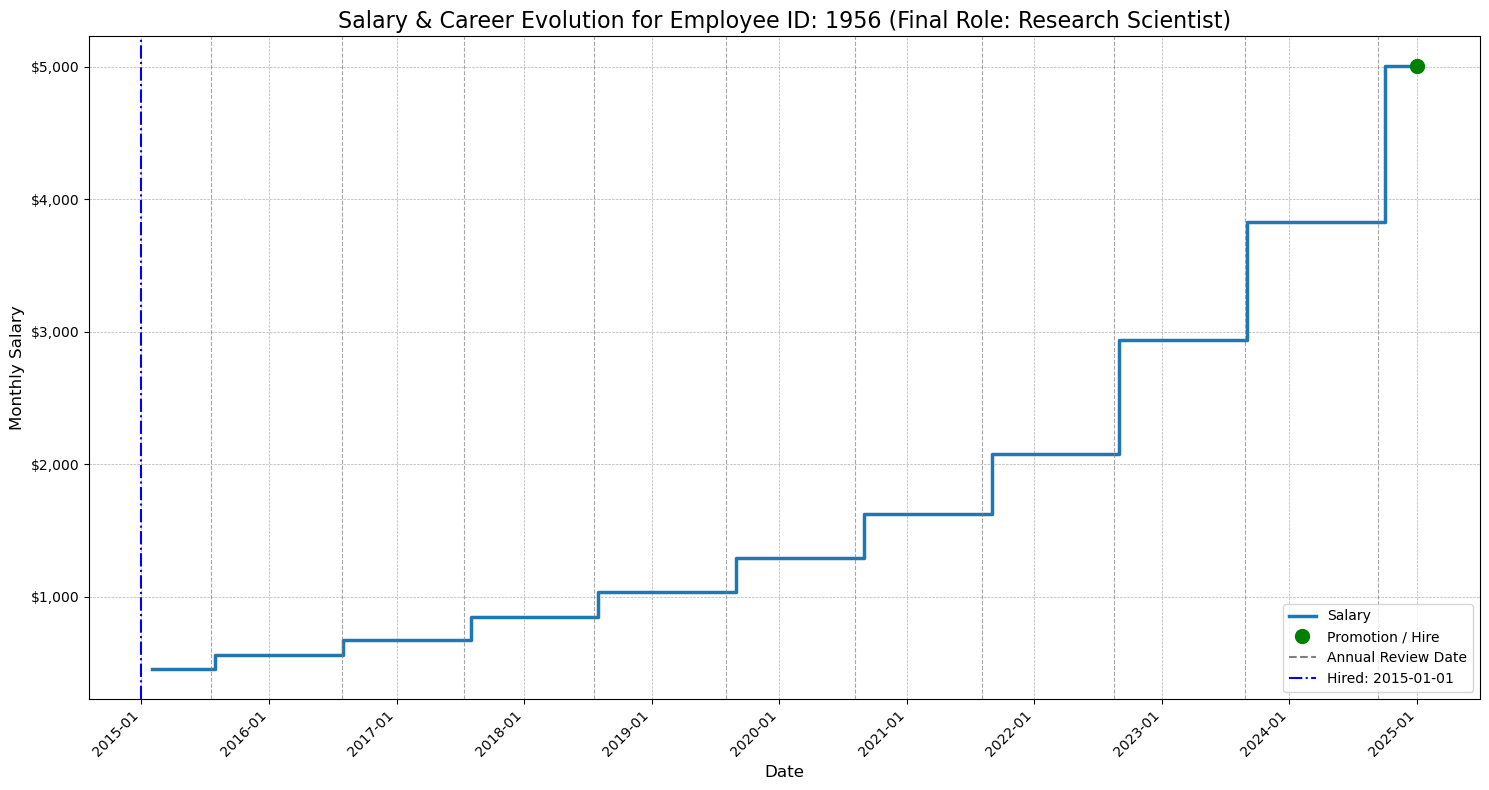

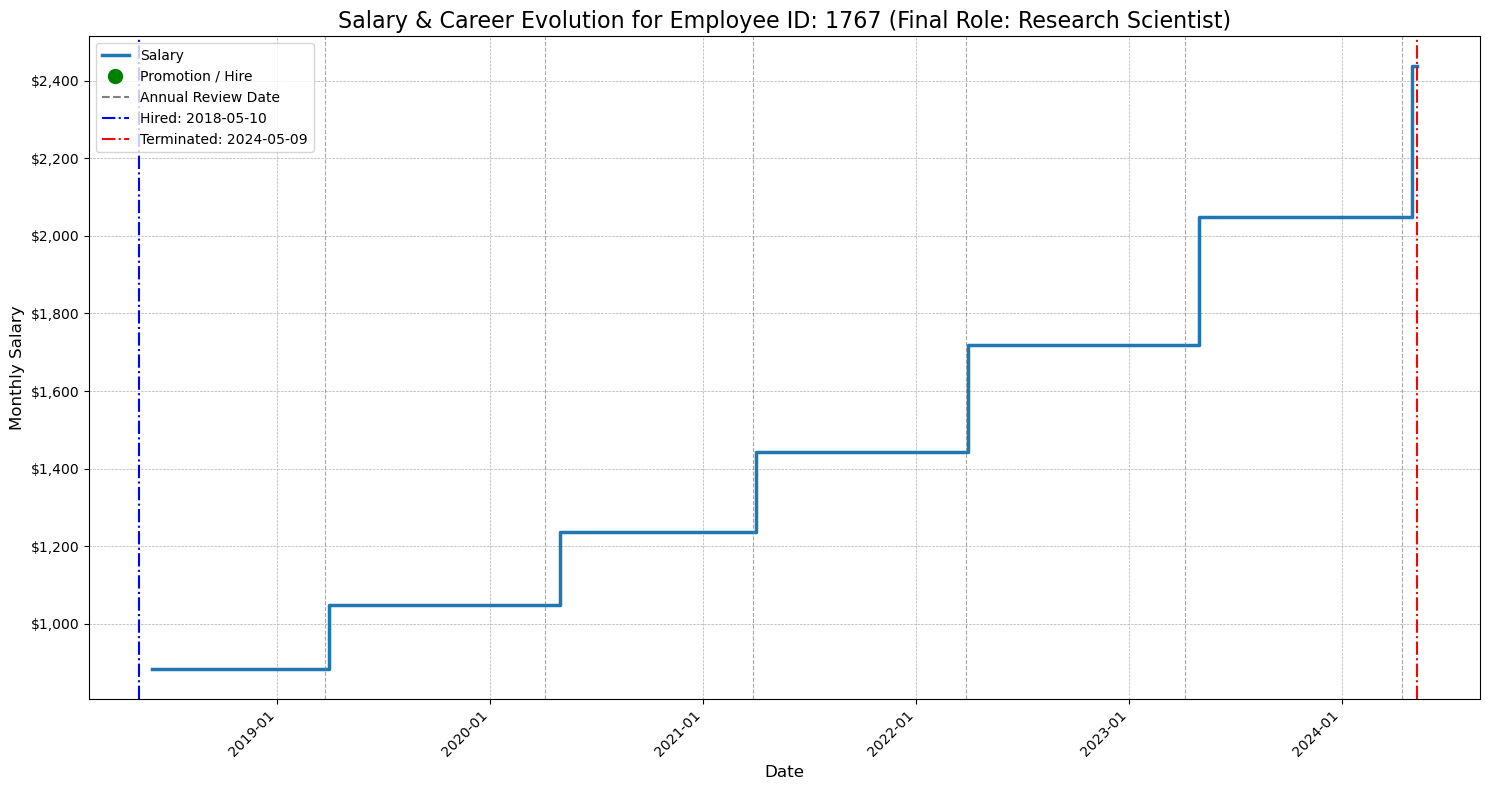

In [181]:
try:
    print("--- Displaying salary evolution for a few sample employees ---")

    amount_of_plots = 1
    for i in range(amount_of_plots):
        active_employee_id = source_df[source_df['attrition'] == 'No']['employee_number'].sample(1).iloc[0]
        plot_employee_salary_evolution(active_employee_id, final_hris_df, reviews_df, all_timelines)
    
        attritted_employee_id = source_df[source_df['attrition'] == 'Yes']['employee_number'].sample(1).iloc[0]
        plot_employee_salary_evolution(attritted_employee_id, final_hris_df, reviews_df, all_timelines)


except NameError as e:
    print(f"\nCould not run the plotting function. Make sure the DataFrames from previous steps are loaded.")
    print(f"Error details: {e}")
except Exception as e:
    print(f"\nAn unexpected error occurred during plotting: {e}")
    import traceback
    traceback.print_exc()

In [180]:
def save_final_log_files(
    hris_df: pd.DataFrame, 
    reviews_df: pd.DataFrame, 
    surveys_df: pd.DataFrame,
    config: dict
) -> None:
    
    print("\n--- Assembling and saving final log files to disk ---")
    
    output_dir = config['OUTPUT_DIR']
    
    try:
        os.makedirs(output_dir, exist_ok=True)
        print(f"Output directory '{output_dir}' is ready.")
    except OSError as e:
        print(f"Error: Could not create directory '{output_dir}'. {e}")
        return

    try:
        hris_path = os.path.join(output_dir, config['OUTPUT_FILES']['hris'])
        hris_cols = [
            'event_date', 'employee_id', 'full_name', 'email', 'job_level', 
            'job_role', 'department_name', 'salary', 'is_currently_active'
        ]
        hris_to_save = hris_df[hris_cols].sort_values(by=['event_date', 'employee_id'])
        hris_to_save.to_csv(hris_path, index=False, date_format='%Y-%m-%d')
        print(f"-> Successfully saved HRIS log to '{hris_path}' ({len(hris_to_save)} rows)")
    except Exception as e:
        print(f"Error saving HRIS log: {e}")

    try:
        reviews_path = os.path.join(output_dir, config['OUTPUT_FILES']['reviews'])
        reviews_cols = [
            'review_date', 'employee_id', 'performance_score', 
            'salary_hike_percent', 'bonus_granted'
        ]
        reviews_to_save = reviews_df[reviews_cols].sort_values(by=['review_date', 'employee_id'])
        reviews_to_save.to_csv(reviews_path, index=False, date_format='%Y-%m-%d')
        print(f"-> Successfully saved Reviews log to '{reviews_path}' ({len(reviews_to_save)} rows)")
    except Exception as e:
        print(f"Error saving Reviews log: {e}")

    try:
        surveys_path = os.path.join(output_dir, config['OUTPUT_FILES']['surveys'])
        surveys_cols = [
            'survey_date', 'employee_id', 'env_satisfaction_score', 
            'job_involvement_score', 'relationship_satisfaction_score', 'job_satisfaction_score'
        ]
        surveys_to_save = surveys_df[surveys_cols].sort_values(by=['survey_date', 'employee_id'])
        surveys_to_save.to_csv(surveys_path, index=False, date_format='%Y-%m-%d')
        print(f"-> Successfully saved Surveys log to '{surveys_path}' ({len(surveys_to_save)} rows)")
    except Exception as e:
        print(f"Error saving Surveys log: {e}")
        
    print("\nPhase 3, Step 4 complete. Core log files have been generated.")


In [164]:
try:
    save_final_log_files(
        final_hris_df,
        reviews_df,
        surveys_df,
        CONFIG
    )
except NameError:
    print("\nCould not save files. Please ensure the DataFrames 'final_hris_df', 'reviews_df', and 'surveys_df' exist.")
except Exception as e:
    print(f"\nAn unexpected error occurred during file saving: {e}")
    import traceback
    traceback.print_exc()


--- Assembling and saving final log files to disk ---
Output directory 'generated_raw_data' is ready.
-> Successfully saved HRIS log to 'generated_raw_data/hris_employees_log.csv' (199491 rows)
-> Successfully saved Reviews log to 'generated_raw_data/reviews_log.csv' (16519 rows)
-> Successfully saved Surveys log to 'generated_raw_data/survey_results_log.csv' (67026 rows)

Phase 3, Step 4 complete. Core log files have been generated.


In [179]:
def generate_erp_financials_log(hris_df: pd.DataFrame, config: dict) -> pd.DataFrame:
    print("\n--- Generating ERP financial log from HRIS data ---")

    min_date = hris_df['event_date'].min()
    max_date = hris_df['event_date'].max()
    monthly_timeline = pd.date_range(min_date, max_date, freq='MS').to_series()
    
    print(f"Simulation timeline spans from {min_date.year} to {max_date.year}.")
    
    all_employees = hris_df['employee_id'].unique()
    employee_month_grid = pd.MultiIndex.from_product(
        [all_employees, monthly_timeline], 
        names=['employee_id', 'period_start_date']
    ).to_frame(index=False)

    hris_df['event_date'] = pd.to_datetime(hris_df['event_date'])
    employee_month_grid['period_start_date'] = pd.to_datetime(employee_month_grid['period_start_date'])

    hris_sorted = hris_df.sort_values('event_date')
    grid_sorted = employee_month_grid.sort_values('period_start_date')
    
    erp_df = pd.merge_asof(
        grid_sorted,
        hris_sorted,
        left_on='period_start_date',
        right_on='event_date',
        by='employee_id',
        direction='backward'
    )
    
    erp_df.dropna(subset=['full_name'], inplace=True)
    erp_df = erp_df[erp_df['is_currently_active'] == True]

    erp_df['total_expense'] = erp_df['salary'] * config['SALARY_OVERHEAD_MULTIPLIER']
    
    financial_summary = erp_df.groupby(['period_start_date', 'department_name']).agg(
        employee_headcount=('employee_id', 'count'),
        actual_expenses=('total_expense', 'sum')
    ).reset_index()

    def calculate_revenue(row):
        dept = row['department_name']
        headcount = row['employee_headcount']
        min_rev, max_rev = config['REVENUE_PER_HEAD_RANGE'].get(dept, (0, 0))
        return headcount * random.uniform(min_rev, max_rev)

    financial_summary['actual_revenue'] = financial_summary.apply(calculate_revenue, axis=1)

    financial_summary['department_code'] = financial_summary['department_name'].map(config['ERP_DEPARTMENT_CODES'])
    financial_summary.rename(columns={'period_start_date': 'period_end_date'}, inplace=True)
    financial_summary['period_end_date'] = financial_summary['period_end_date'] + pd.offsets.MonthEnd(0)
    
    final_cols = [
        'period_end_date', 'department_code', 'actual_revenue', 
        'actual_expenses', 'employee_headcount'
    ]
    erp_final_df = financial_summary[final_cols].sort_values('period_end_date').reset_index(drop=True)
    
    print(f"Generated {len(erp_final_df)} monthly financial records across all departments.")
    return erp_final_df

In [174]:
try:
    erp_financials_df = generate_erp_financials_log(final_hris_df, CONFIG)
    
    output_dir = CONFIG['OUTPUT_DIR']
    erp_path = os.path.join(output_dir, CONFIG['OUTPUT_FILES']['erp'])
    erp_financials_df.to_csv(erp_path, index=False, date_format='%Y-%m-%d')
    
    print(f"-> Successfully saved ERP Financials log to '{erp_path}'")
    
    print("\n--- Sample of Final ERP Financials Log ---")
    display(erp_financials_df.head())
    
except NameError:
    print("\nCould not generate ERP log. Please ensure the DataFrame 'final_hris_df' exists.")
except Exception as e:
    print(f"\nAn unexpected error occurred during ERP log generation: {e}")
    import traceback
    traceback.print_exc()


--- Generating ERP financial log from HRIS data ---
Simulation timeline spans from 1983 to 2024.
Generated 1385 monthly financial records across all departments.
-> Successfully saved ERP Financials log to 'generated_raw_data/erp_financials_log.csv'

--- Sample of Final ERP Financials Log ---


,period_end_date,department_code,actual_revenue,actual_expenses,employee_headcount
0,1983-07-31,RD,15140.082903,38.808,1
1,1983-08-31,RD,15388.047057,38.808,1
2,1983-09-30,RD,18796.057334,38.808,1
3,1983-10-31,RD,20012.344023,38.808,1
4,1983-11-30,RD,49241.544469,88.648,2


--- Displaying department headcount and HR expense trends from 2010 onwards ---

Could not run the plotting function. Make sure the 'erp_financials_df' DataFrame is loaded.


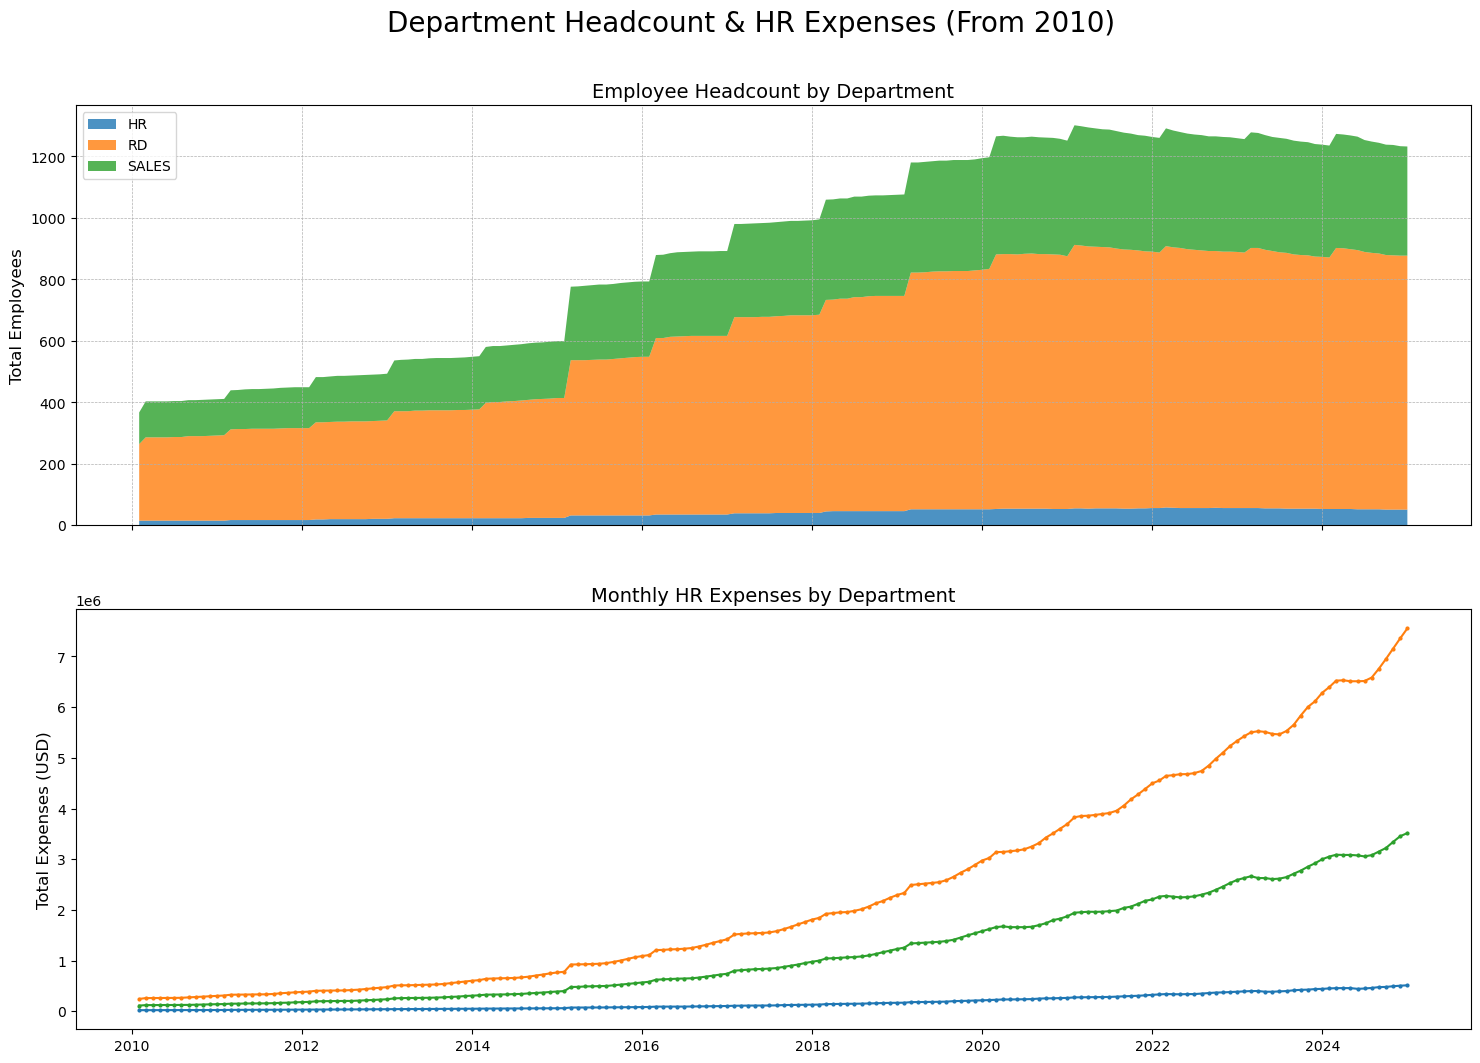

In [178]:
def plot_company_growth_trends(erp_df: pd.DataFrame, start_year: int = 2010):
    if erp_df.empty:
        print("ERP DataFrame is empty. Cannot generate plots.")
        return
        
    erp_df['period_end_date'] = pd.to_datetime(erp_df['period_end_date'])
    
    start_date = f"{start_year}-01-01"
    filtered_df = erp_df[erp_df['period_end_date'] >= start_date].copy()

    if filtered_df.empty:
        print(f"No data available from {start_year} onwards. Cannot generate plot.")
        return

    headcount_pivot = filtered_df.pivot(
        index='period_end_date', 
        columns='department_code', 
        values='employee_headcount'
    ).fillna(0)

    expenses_pivot = filtered_df.pivot(
        index='period_end_date', 
        columns='department_code', 
        values='actual_expenses'
    ).fillna(0)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18, 12), sharex=True)
    fig.suptitle(f'Department Headcount & HR Expenses (From {start_year})', fontsize=20, y=0.96)

    ax1.stackplot(
        headcount_pivot.index,
        headcount_pivot.values.T,
        labels=headcount_pivot.columns,
        alpha=0.8
    )
    ax1.set_title('Employee Headcount by Department', fontsize=14)
    ax1.set_ylabel('Total Employees', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', linewidth=0.5)

    for dept in expenses_pivot.columns:
        ax2.plot(expenses_pivot.index, expenses_pivot[dept], label=dept, marker='.', markersize=4, linestyle='-')

    ax2.set_title('Monthly HR Expenses by Department', fontsize=14)
    ax2.set_ylabel('Total Expenses (USD)', fontsize=12)
    
    def currency_formatter(x, pos):
        if x >= 1_000_000:
            return f'${x*1e-6:1.1f}M'
        return f'${x*1e-3:1.0f}K'
    ax2.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
    
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle='--', linewidth=0.5)

    ax2.set_xlabel('Date', fontsize=12)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


try:
    print("--- Displaying department headcount and HR expense trends from 2010 onwards ---")
    plot_company_growth_trends(erp_financials_df, start_year=2010)
    
except NameError:
    print("\nCould not run the plotting function. Make sure the 'erp_financials_df' DataFrame is loaded.")
except Exception as e:
    print(f"\nAn unexpected error occurred during plotting: {e}")
    import traceback
    traceback.print_exc()

In [191]:
def create_snapshots_from_logs(
    hris_df: pd.DataFrame, 
    reviews_df: pd.DataFrame, 
    surveys_df: pd.DataFrame, 
    erp_df: pd.DataFrame, 
    config: dict,
    start_year: int = 2010
):
    print(f"\n--- Starting snapshot generation from {start_year} ---")

    main_snapshot_dir = config['SNAPSHOT_DIR']
    system_dirs = {
        'hris': os.path.join(main_snapshot_dir, 'hris'),
        'erp': os.path.join(main_snapshot_dir, 'erp'),
        'reviews': os.path.join(main_snapshot_dir, 'reviews'),
        'surveys': os.path.join(main_snapshot_dir, 'surveys'),
    }
    
    for path in system_dirs.values():
        os.makedirs(path, exist_ok=True)
    print(f"Created snapshot directory structure inside '{main_snapshot_dir}'.")


    hris_df['event_date'] = pd.to_datetime(hris_df['event_date'])
    reviews_df['review_date'] = pd.to_datetime(reviews_df['review_date'])
    surveys_df['survey_date'] = pd.to_datetime(surveys_df['survey_date'])
    erp_df['period_end_date'] = pd.to_datetime(erp_df['period_end_date'])
    
    hris_sorted = hris_df.sort_values('event_date')
    all_employees = hris_df['employee_id'].unique()
    
    start_date = f"{start_year}-01-01"
    max_date = hris_df['event_date'].max()
    snapshot_dates = pd.date_range(start_date, max_date, freq='M') 
    
    print(f"Generating {len(snapshot_dates)} monthly snapshots from {snapshot_dates[0].date()} to {snapshot_dates[-1].date()}...")

    for snapshot_date in tqdm(snapshot_dates, desc="Generating Snapshots"):
        date_str = snapshot_date.strftime('%Y-%m-%d')
        
        grid = pd.DataFrame({'employee_id': all_employees, 'snapshot_date': snapshot_date})
        hris_snapshot = pd.merge_asof(
            grid.sort_values('snapshot_date'),
            hris_sorted,
            left_on='snapshot_date',
            right_on='event_date',
            by='employee_id',
            direction='backward'
        )
        hris_snapshot.dropna(subset=['full_name'], inplace=True)
        hris_snapshot = hris_snapshot[hris_snapshot['is_currently_active'] == True]
        
        if not hris_snapshot.empty:
            hris_path = os.path.join(system_dirs['hris'], f"hris_snapshot_{date_str}.csv")
            hris_snapshot.to_csv(hris_path, index=False, date_format='%Y-%m-%d')

        erp_snapshot = erp_df[erp_df['period_end_date'] == snapshot_date]
        if not erp_snapshot.empty:
            erp_path = os.path.join(system_dirs['erp'], f"erp_snapshot_{date_str}.csv")
            erp_snapshot.to_csv(erp_path, index=False, date_format='%Y-%m-%d')
            
        start_of_month = snapshot_date.replace(day=1)
        reviews_snapshot = reviews_df[
            (reviews_df['review_date'] >= start_of_month) & 
            (reviews_df['review_date'] <= snapshot_date)
        ]
        if not reviews_snapshot.empty:
            reviews_path = os.path.join(system_dirs['reviews'], f"reviews_snapshot_{date_str}.csv")
            reviews_snapshot.to_csv(reviews_path, index=False, date_format='%Y-%m-%d')
            
        surveys_snapshot = surveys_df[
            (surveys_df['survey_date'] >= start_of_month) & 
            (surveys_df['survey_date'] <= snapshot_date)
        ]
        if not surveys_snapshot.empty:
            surveys_path = os.path.join(system_dirs['surveys'], f"surveys_snapshot_{date_str}.csv")
            surveys_snapshot.to_csv(surveys_path, index=False, date_format='%Y-%m-%d')

    print("\nSnapshot generation complete. All files saved to the 'snapshots' directory.")


try:
    create_snapshots_from_logs(
        final_hris_df,
        reviews_df,
        surveys_df,
        erp_financials_df,
        CONFIG,
        start_year=2010
    )
except NameError:
    print("\nCould not generate snapshots. Please ensure the final DataFrames are loaded in memory.")
except Exception as e:
    print(f"\nAn unexpected error occurred during snapshot generation: {e}")
    import traceback
    traceback.print_exc()

/tmp/ipykernel_1057739/2502937550.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  snapshot_dates = pd.date_range(start_date, max_date, freq='M') # 'M' gives month-end dates



--- Starting snapshot generation from 2010 ---
Created snapshot directory structure inside 'snapshots'.
Generating 180 monthly snapshots from 2010-01-31 to 2024-12-31...


Generating Snapshots: 100%|██████████████████████████████████| 180/180 [00:02<00:00, 61.25it/s]


Snapshot generation complete. All files saved to the 'snapshots' directory.
